**1. Environment**

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 94 GB / available: 86 GB / percent used: 8.3 %


**2. Geographical coordinates**

In [3]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

(<matplotlib.lines.Line2D at 0x7f67a1376190>,)

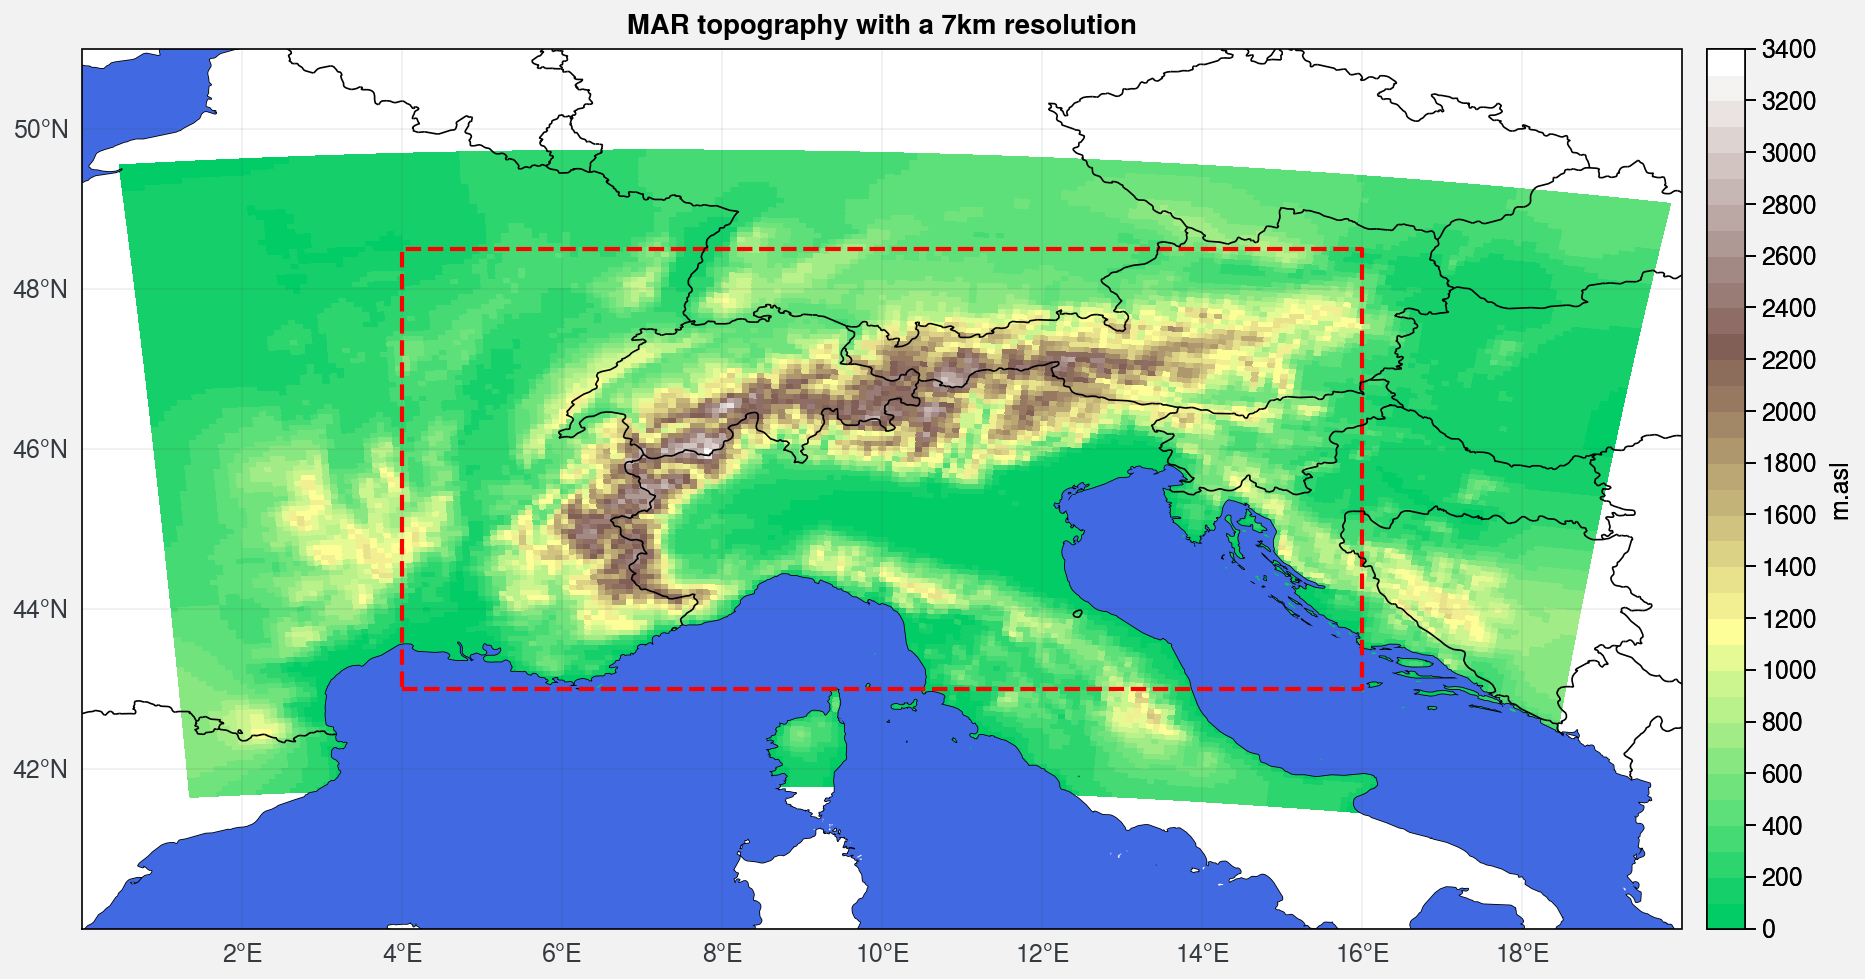

In [2]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')
ax.format(**normal_format,suptitle='MAR topography with a 7km resolution')
ax.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

**3 Seasonal means**

In [6]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [7]:
first_year = 1902
last_year = 2010
les_season_mean = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBrr.'+str(year)+'.nc')
    ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBsf.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_rr.MBrr+ds_sf.MBsf).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_mean[year-first_year] = season_mean_year
    
print(les_season_mean.shape)
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/les_season_mean.npy', les_season_mean)

1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 (109, 4, 126, 201)


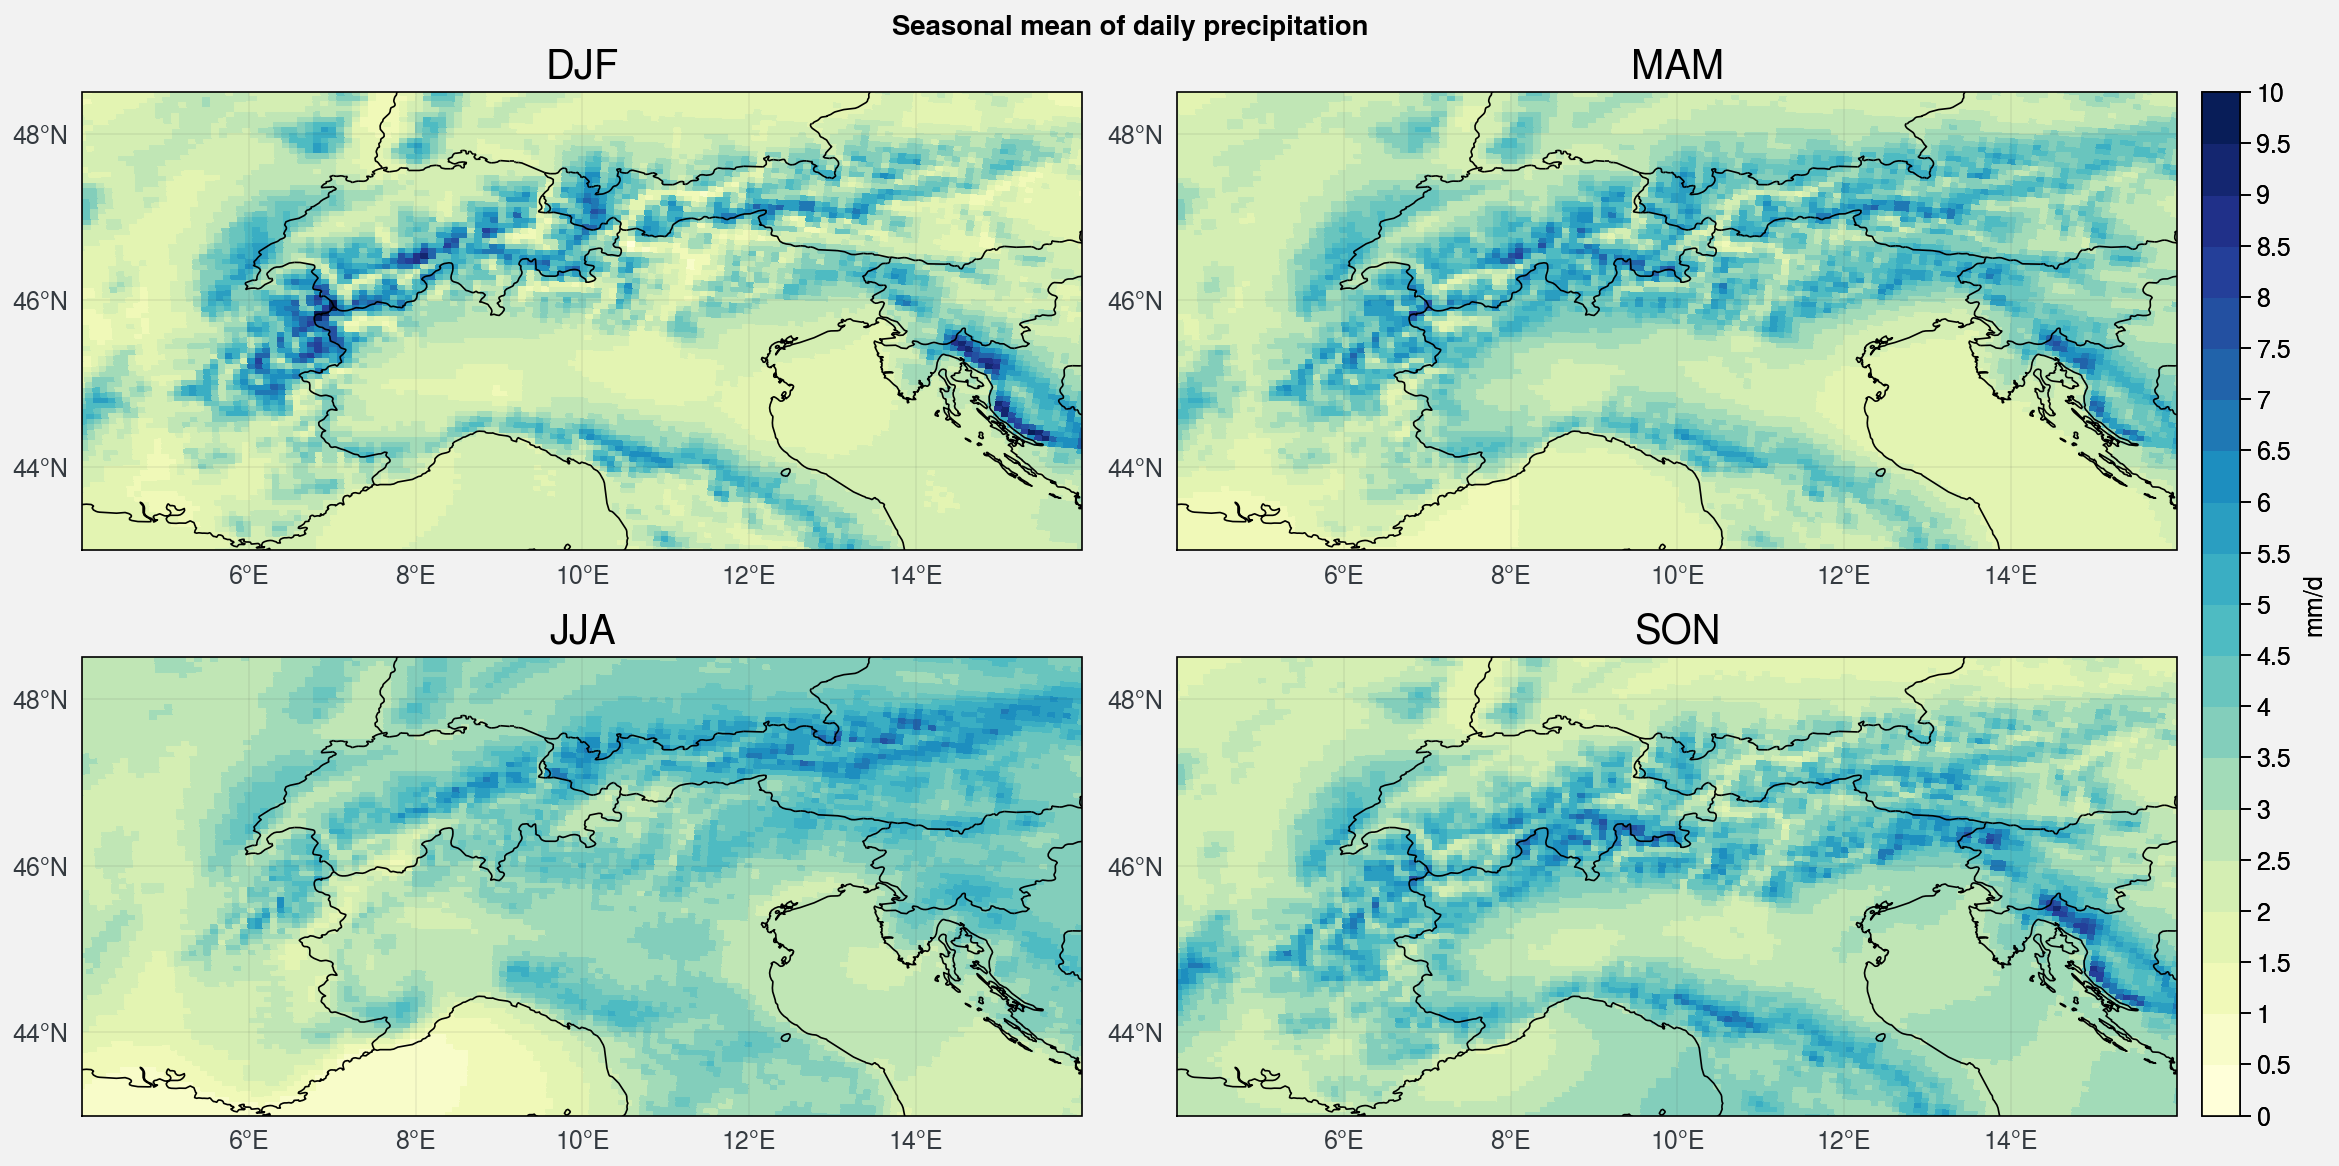

In [9]:
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/les_season_mean.npy')
seasonal_mean = np.mean(les_season_mean,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal mean of daily precipitation")


In [11]:
def trends(seasonal_data):
    ntime,ns,nlat,nlon = np.shape(seasonal_data)
    slope= np.zeros((ns,nlat,nlon))
    # pvalue=np.zeros((ns,nlat,nlon))
    for lon in range(nlon):
        print(str(lon),end=' ')
        for lat in range(nlat):
            for season in range(4):
                linregress = stats.linregress(range(ntime), seasonal_data[:,season,lat,lon])
                slope[season,lat,lon] = linregress.slope
                # pvalue[season][lat][lon] = linregress.pvalue
    return slope
trend_mean = trends(les_season_mean)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

/tmp/ipykernel_1170/200499731.py:12: RuntimeWarning: invalid value encountered in true_divide
  m = ax.pcolormesh(ds.LON,ds.LAT,100*100*trend_mean[i,:,:]/seasonal_mean[i,:,:],levels=np.linspace(-100,100,21),cmap='BrBg')


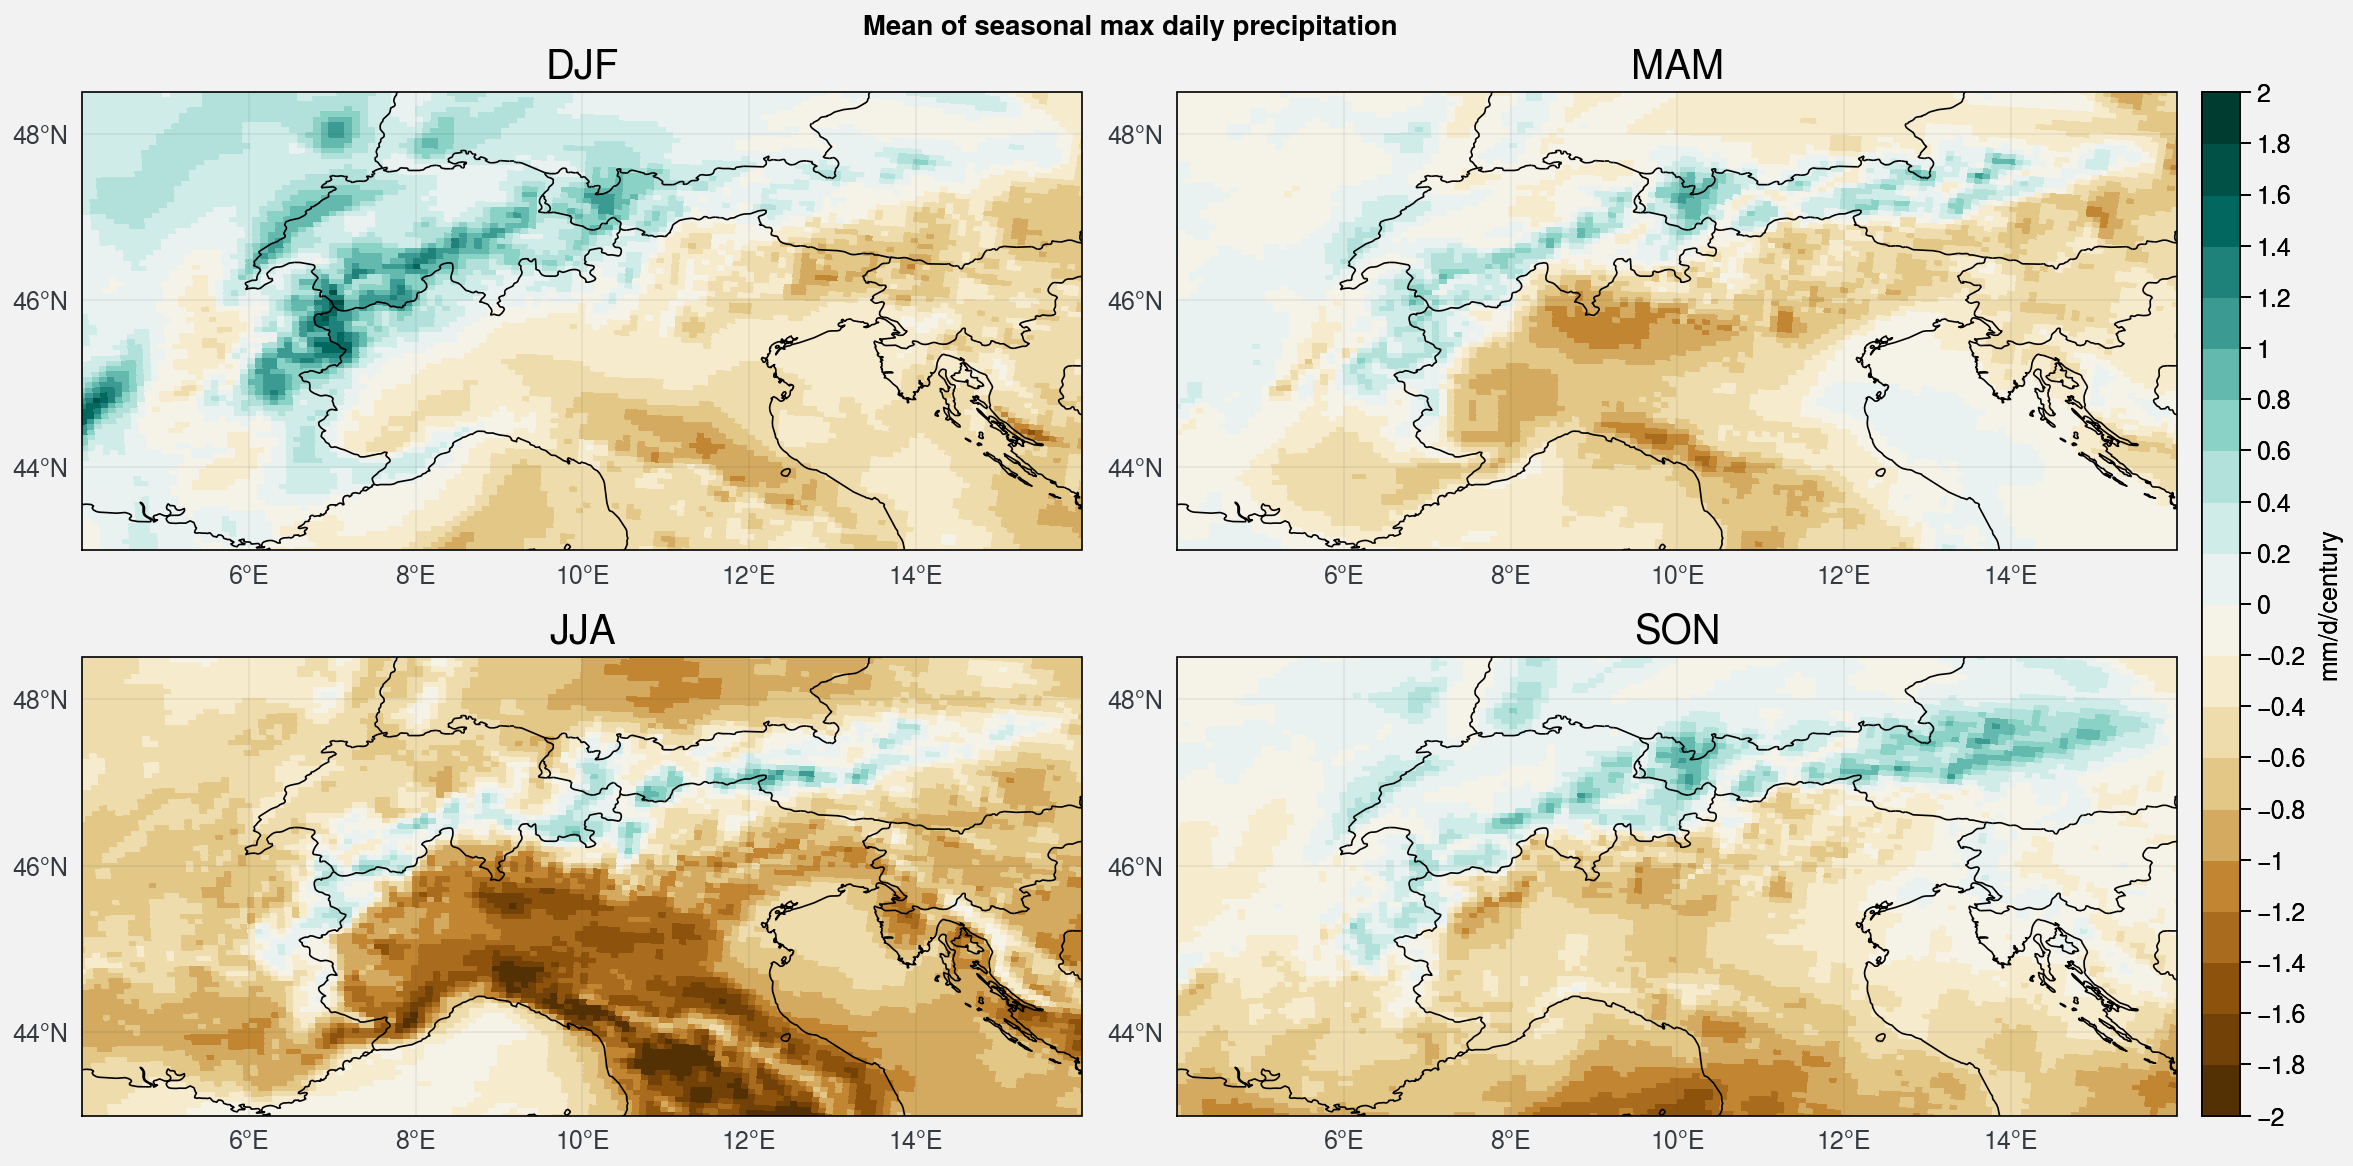

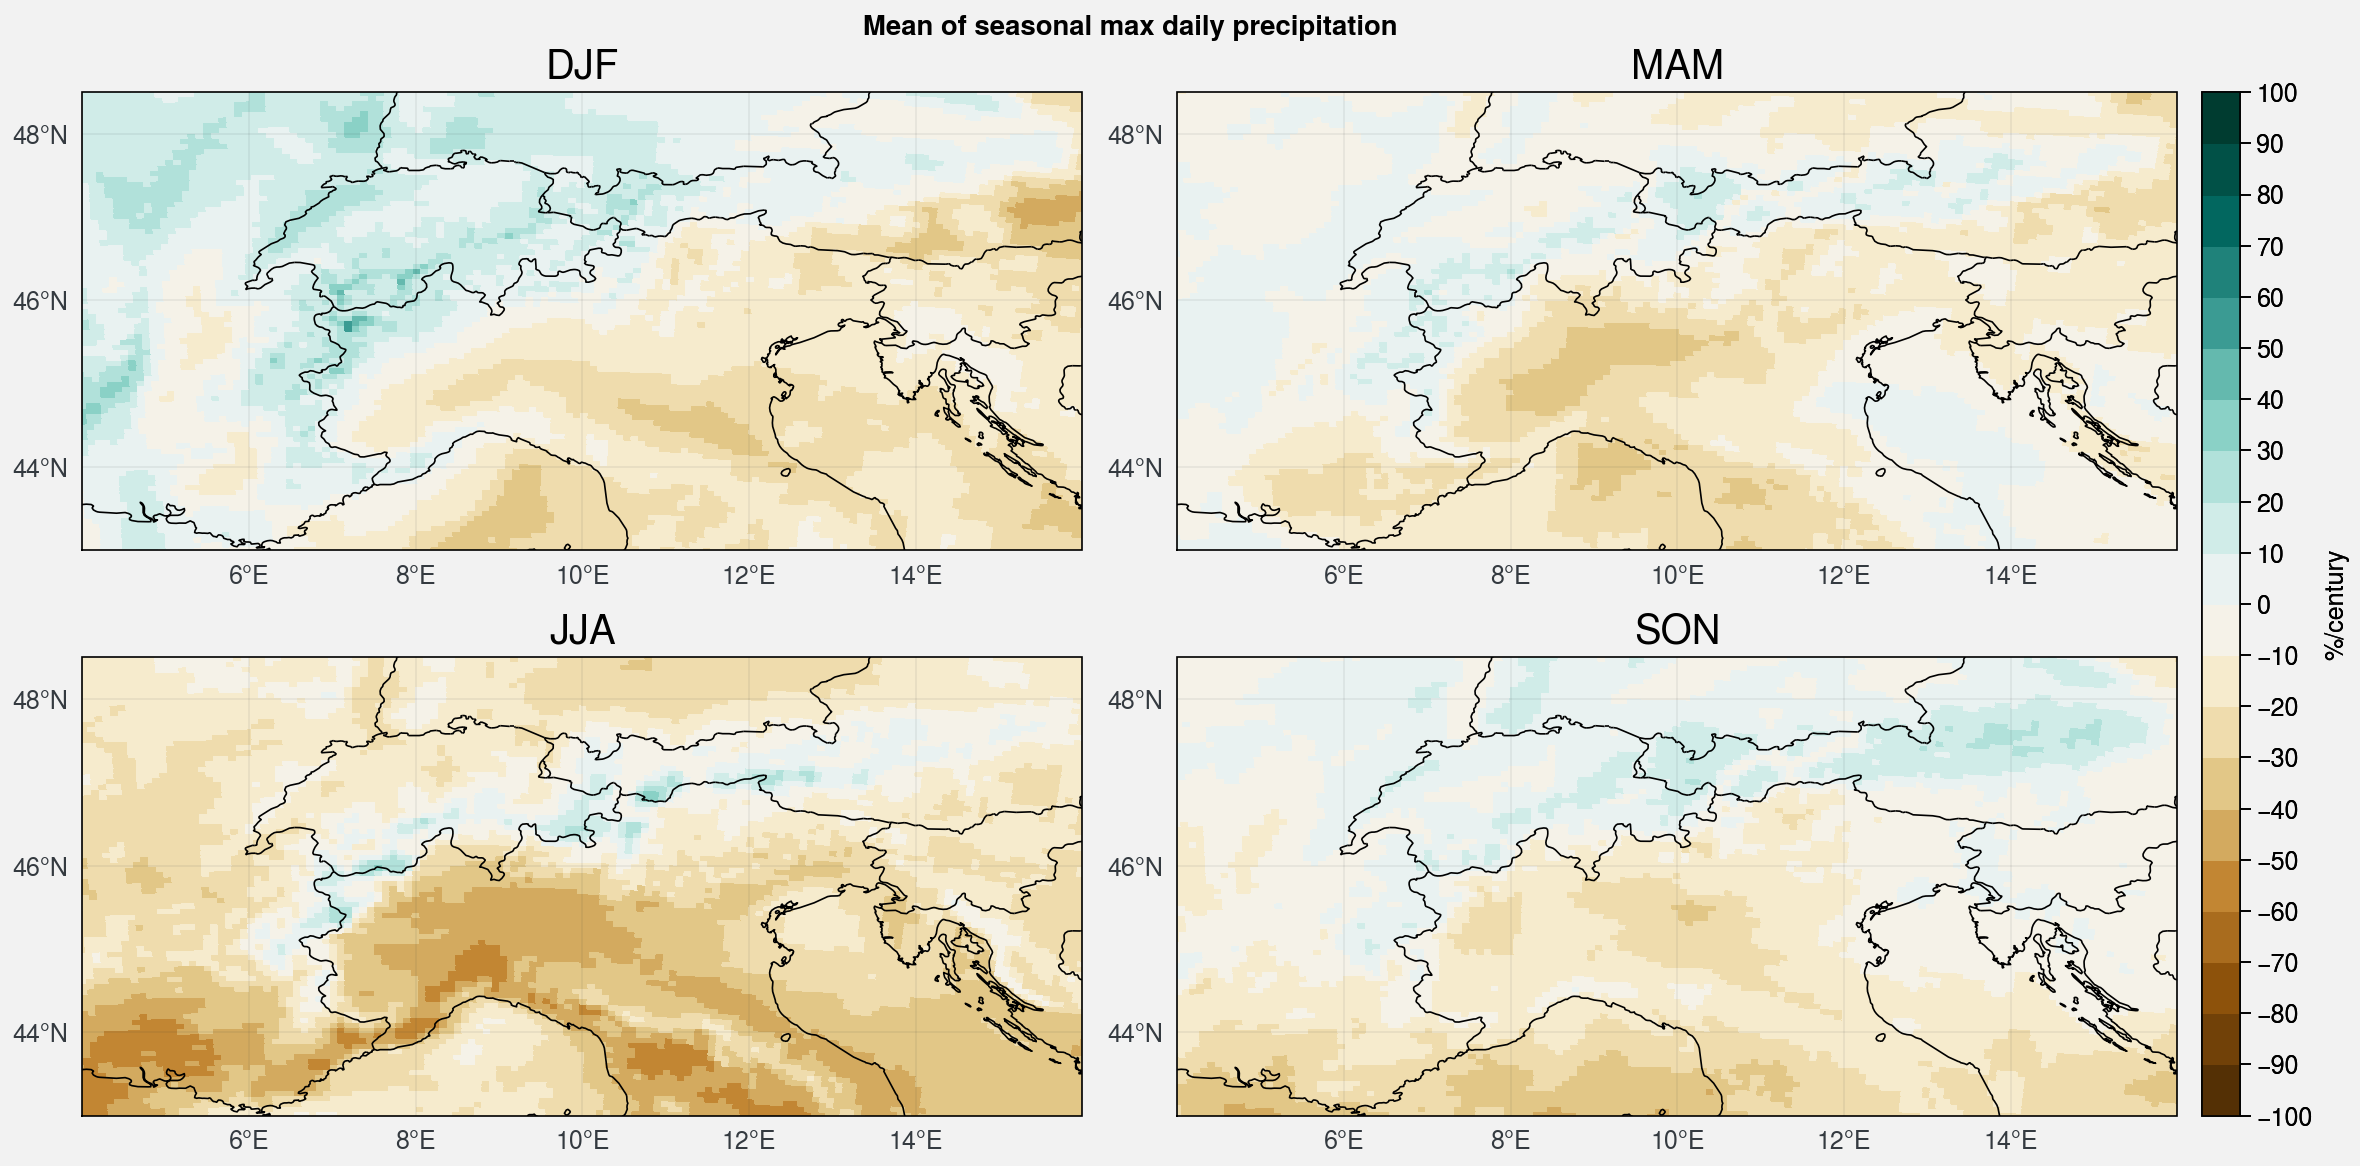

In [19]:
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,100*trend_mean[i,:,:],levels=np.linspace(-2,2,21),cmap='BrBg')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d/century')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")


f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,100*100*trend_mean[i,:,:]/seasonal_mean[i,:,:],levels=np.linspace(-100,100,21),cmap='BrBg')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '%/century')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")

**3.3 Relation precipitation/altitude**

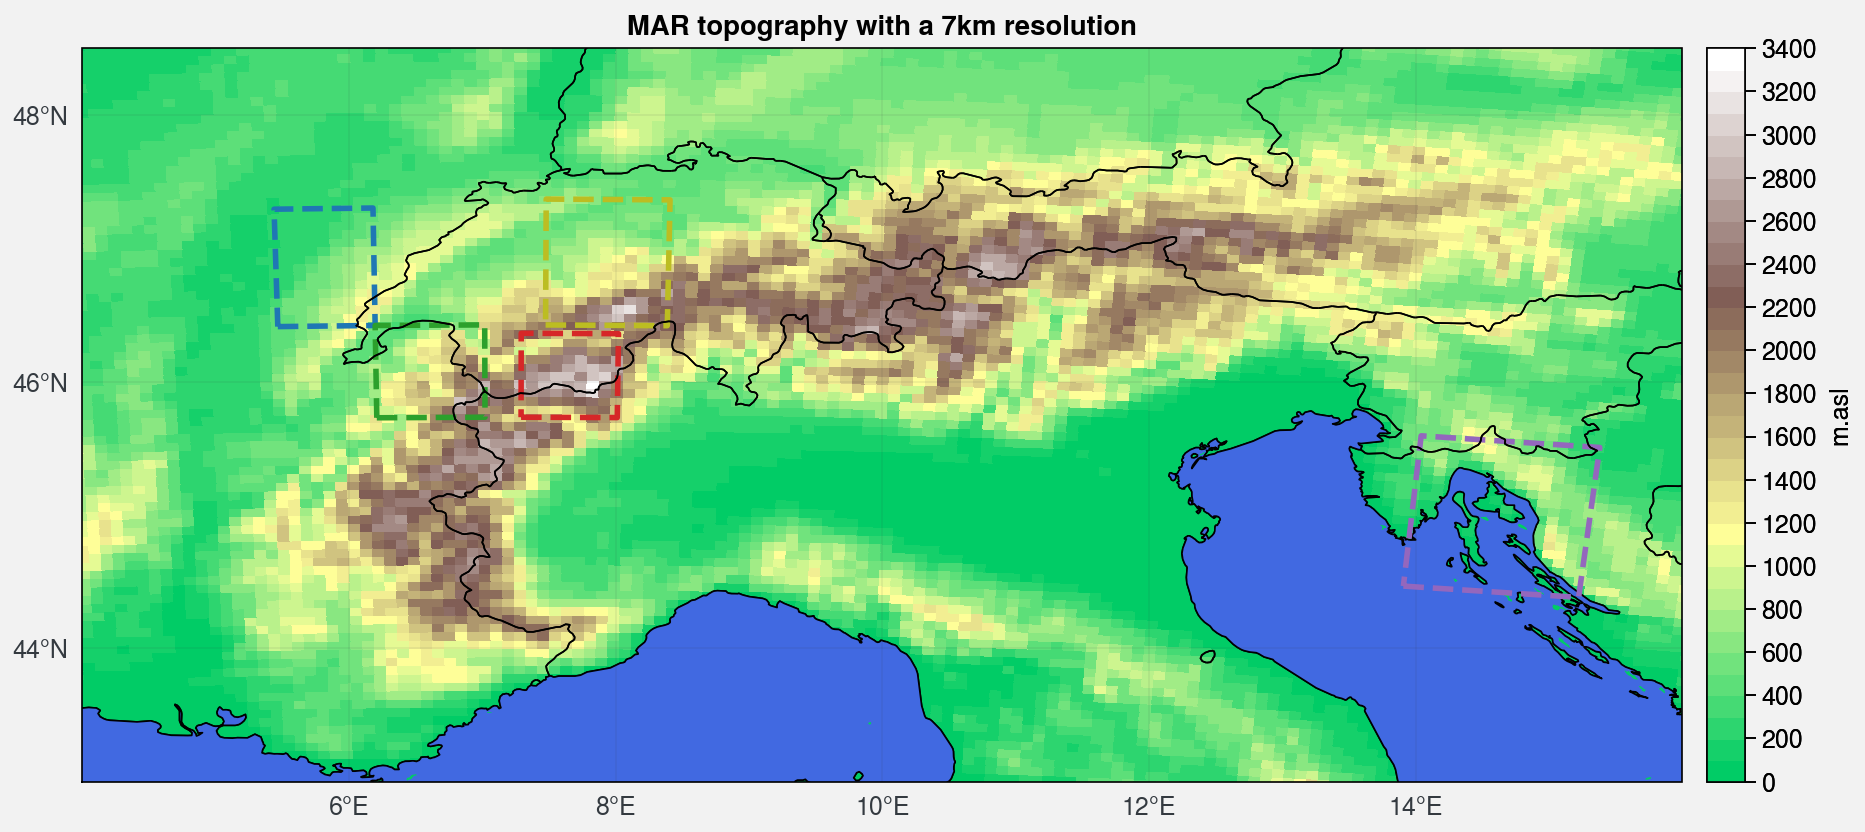

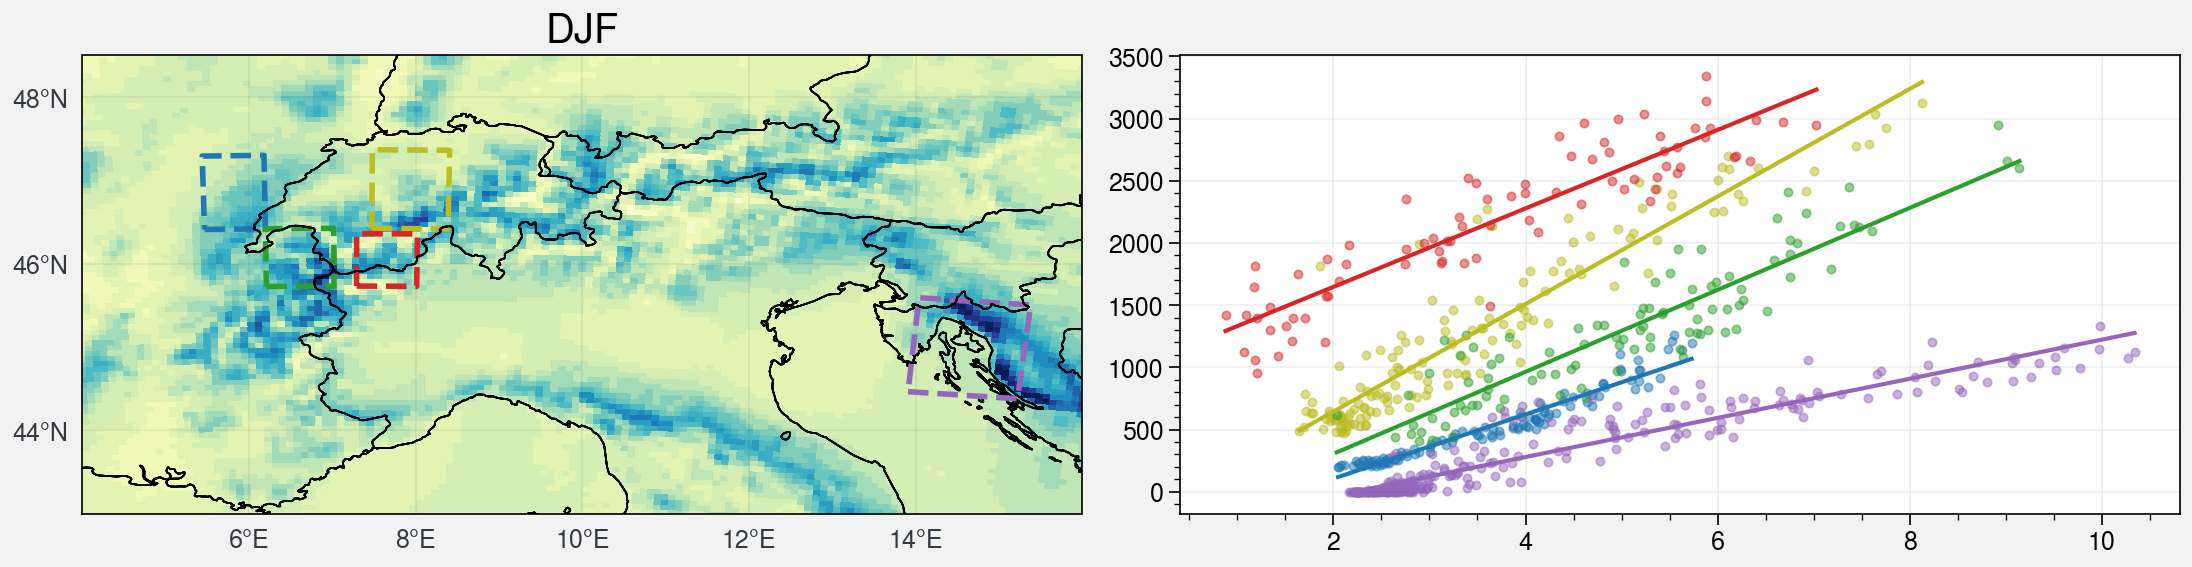

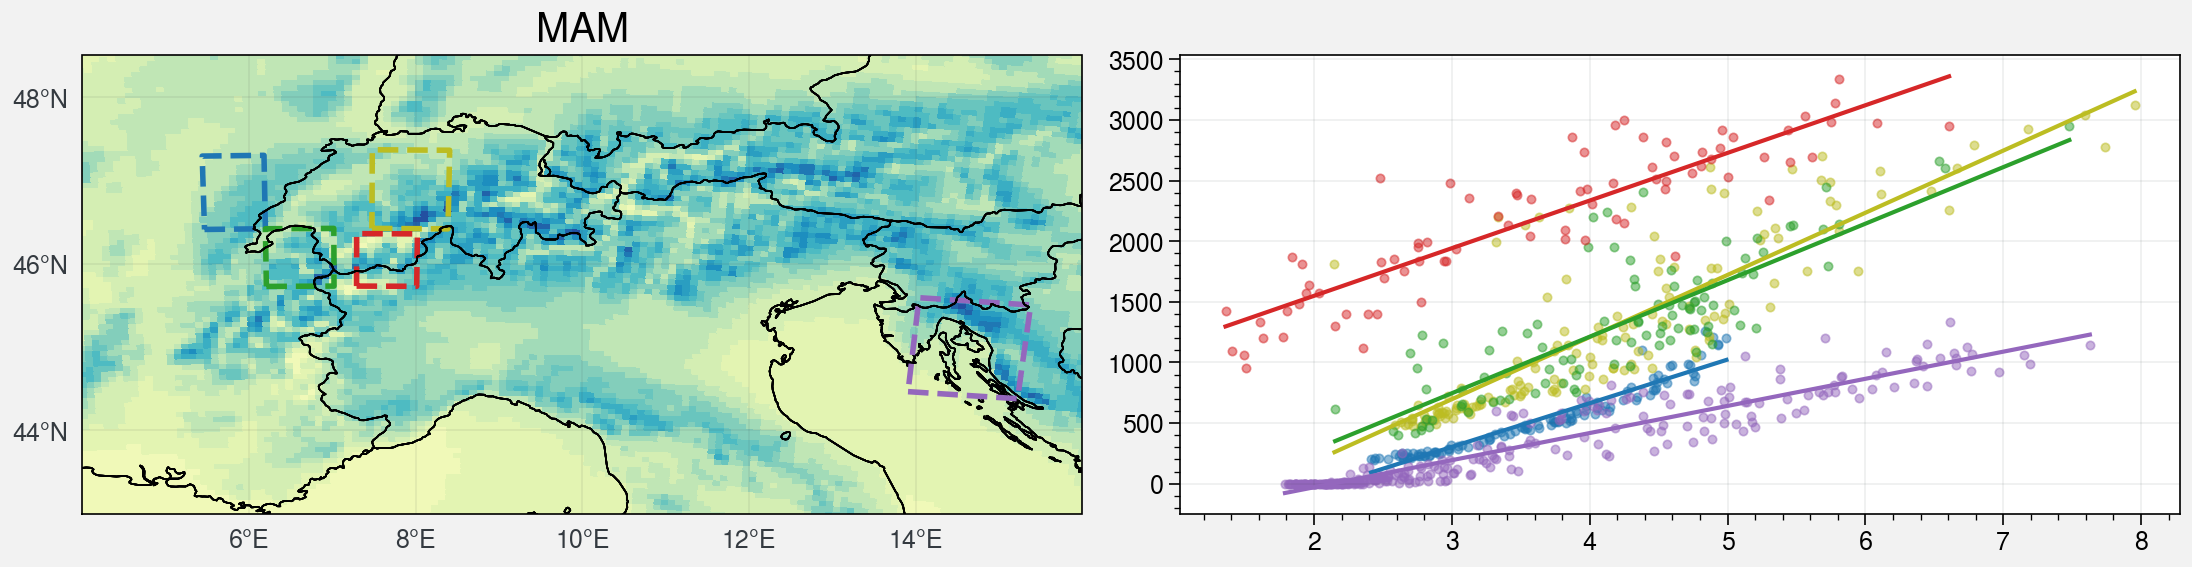

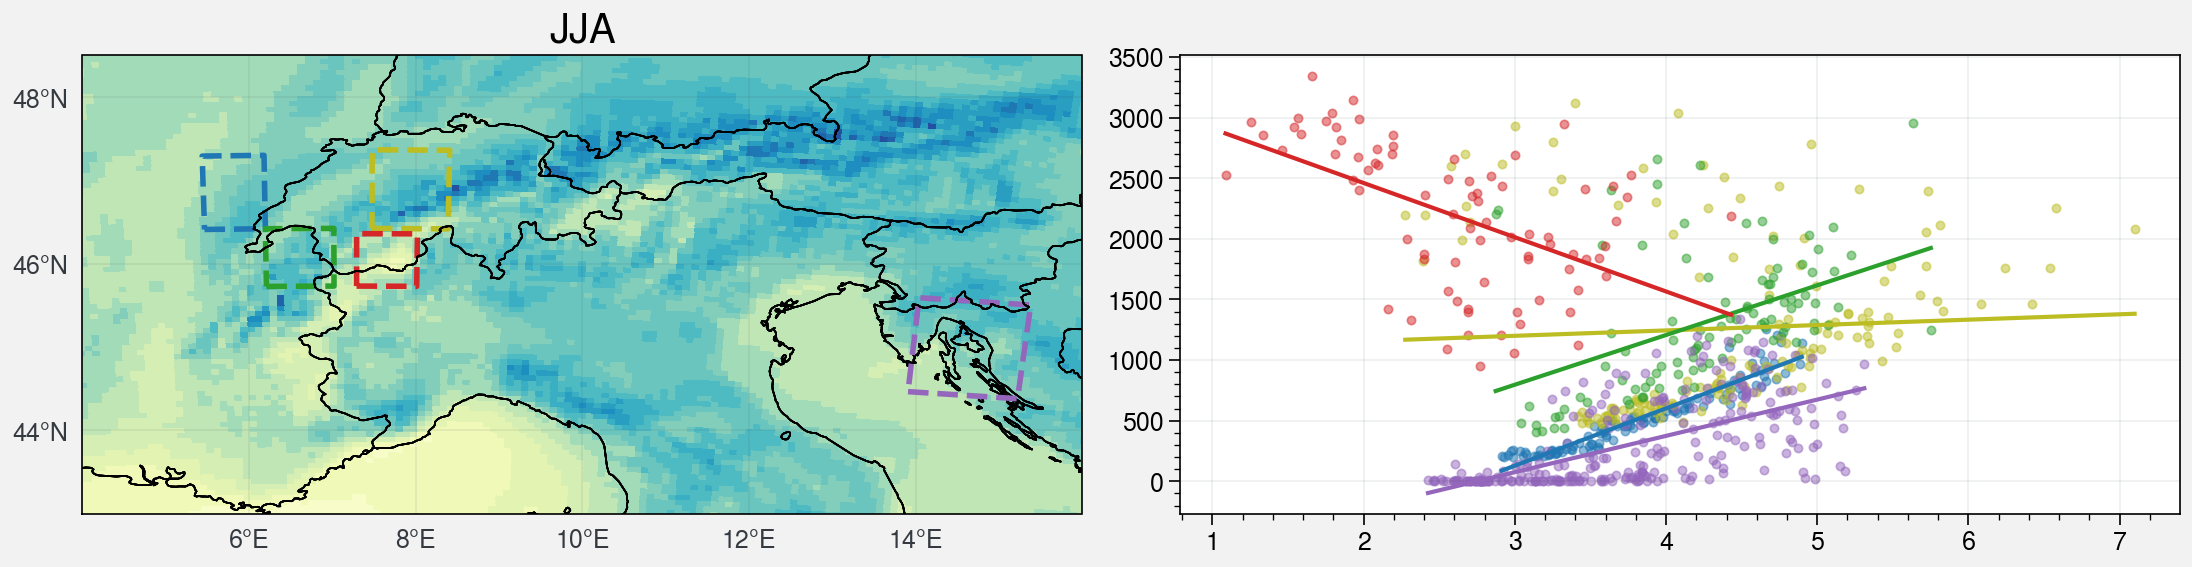

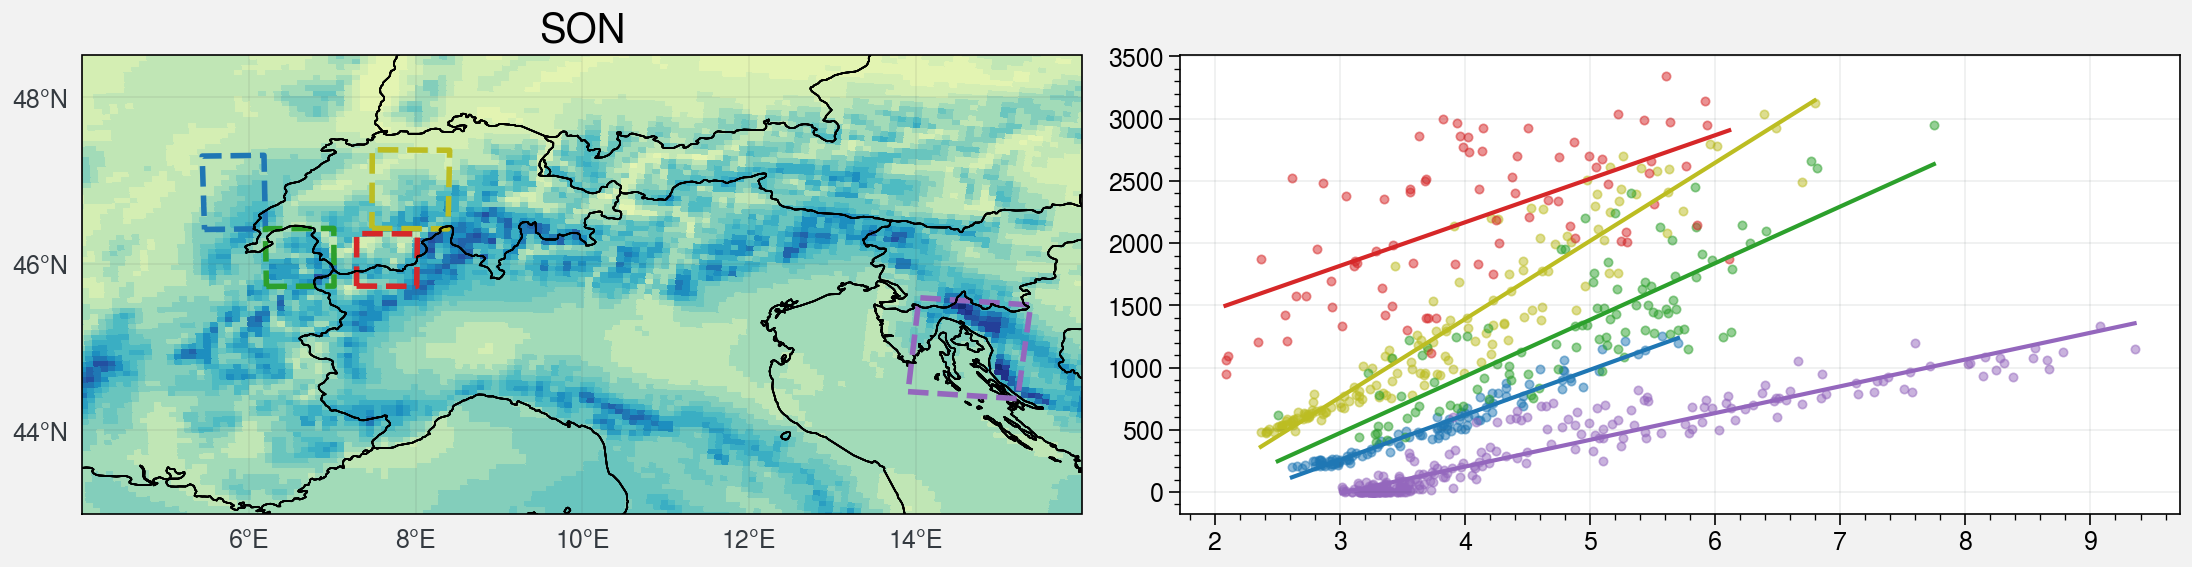

In [26]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
fh, axh = pplt.subplots(proj='cyl', axwidth=8)
m=axh.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
fh.colorbar(m,label= 'm.asl')
axh.format(**normal_format,ocean=True,oceancolor='royalblue',suptitle='MAR topography with a 7km resolution')

colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']

for season in range(4):
    f, axs = pplt.subplots(proj=('cyl',None),ncols=2, nrows=1, share=1, axwidth=5)
    for region in range(5):
        if region==0:
            i1 = 50 ; i2 = 58 ; j1 = 73 ; j2 = 87 # jura
            # i1 = 100 ; i2 = 120 ; j1 = 35 ; j2 = 45 # appenins
        if region==1:
            i1 = 72 ; i2 = 82 ; j1 = 73 ; j2 = 88 # suisse
        if region==2:
            i1 = 58 ; i2 = 67 ; j1 = 62 ; j2 = 73 # savoie
        if region==3:
            i1 = 70 ; i2 = 78 ; j1 = 62 ; j2 = 72 # mont rose
        if region==4:
            i1 = 145 ; i2 = 160 ; j1 = 45 ; j2 = 63 # croatie
        if region==5:
            i1 = 123 ; i2 = 137 ; j1 = 84 ; j2 = 90 # grossglokner
            # i1 = 100 ; i2 = 130 ; j1 = 82 ; j2 = 92 # tirol
            # i1 = 105 ; i2 = 120 ; j1 = 65 ; j2 = 80 # sud tirol

        m = axs[0].pcolormesh(ds.LON,ds.LAT,seasonal_mean[season,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu' )
        axs[0].format(**normal_format,title=['DJF','MAM','JJA', 'SON'][season],titlesize='20px')

        axs[0].plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
        if season==0:
            axh.plot( [ ds.LON[j1,i1],ds.LON[j1,i2],ds.LON[j2,i2],ds.LON[j2,i1],ds.LON[j1,i1] ],
                  [ ds.LAT[j1,i1],ds.LAT[j1,i2],ds.LAT[j2,i2],ds.LAT[j2,i1],ds.LAT[j1,i1] ] , '--',color=colors[region],linewidth=2)
            
        h = np.array(ds.SH[j1:j2,i1:i2].stack(z=('x','y')) )
        p = np.ndarray.flatten(seasonal_mean[season,j1:j2,i1:i2],order='F')
        #p = seasonal_mean[season,j1:j2,i1:i2].stack(z=('x','y'))
        axs[1].scatter( p, h ,marker='.',alpha=0.5,color=colors[region])

        m, b = np.polyfit(p, h, 1)
        x= np.linspace(np.min(p),np.max(p),2)
        axs[1].plot(x, m*x + b,color=colors[region])

**4 Extremes**

In [9]:
first_year = 1902
last_year = 2010
les_max_year = np.zeros(((last_year-first_year+1),126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBrr.'+str(year)+'.nc')
    ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBsf.'+str(year)+'.nc')
    max_year=(ds_rr.MBrr+ds_sf.MBsf).max(axis=0)
    les_max_year[year-first_year] = max_year
    
print(les_max_year.shape)

1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 (126, 201)
(109, 126, 201)


In [14]:
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/les_max_year.npy', les_max_year)

In [6]:
les_max_year = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/les_max_year.npy')

0.15040424236871858 53.32217842182139 11.285891694955799
0.0912657820340211 50.304712493004445 10.400375771813415
0.236061830453426 56.77162793534433 11.579733041309488


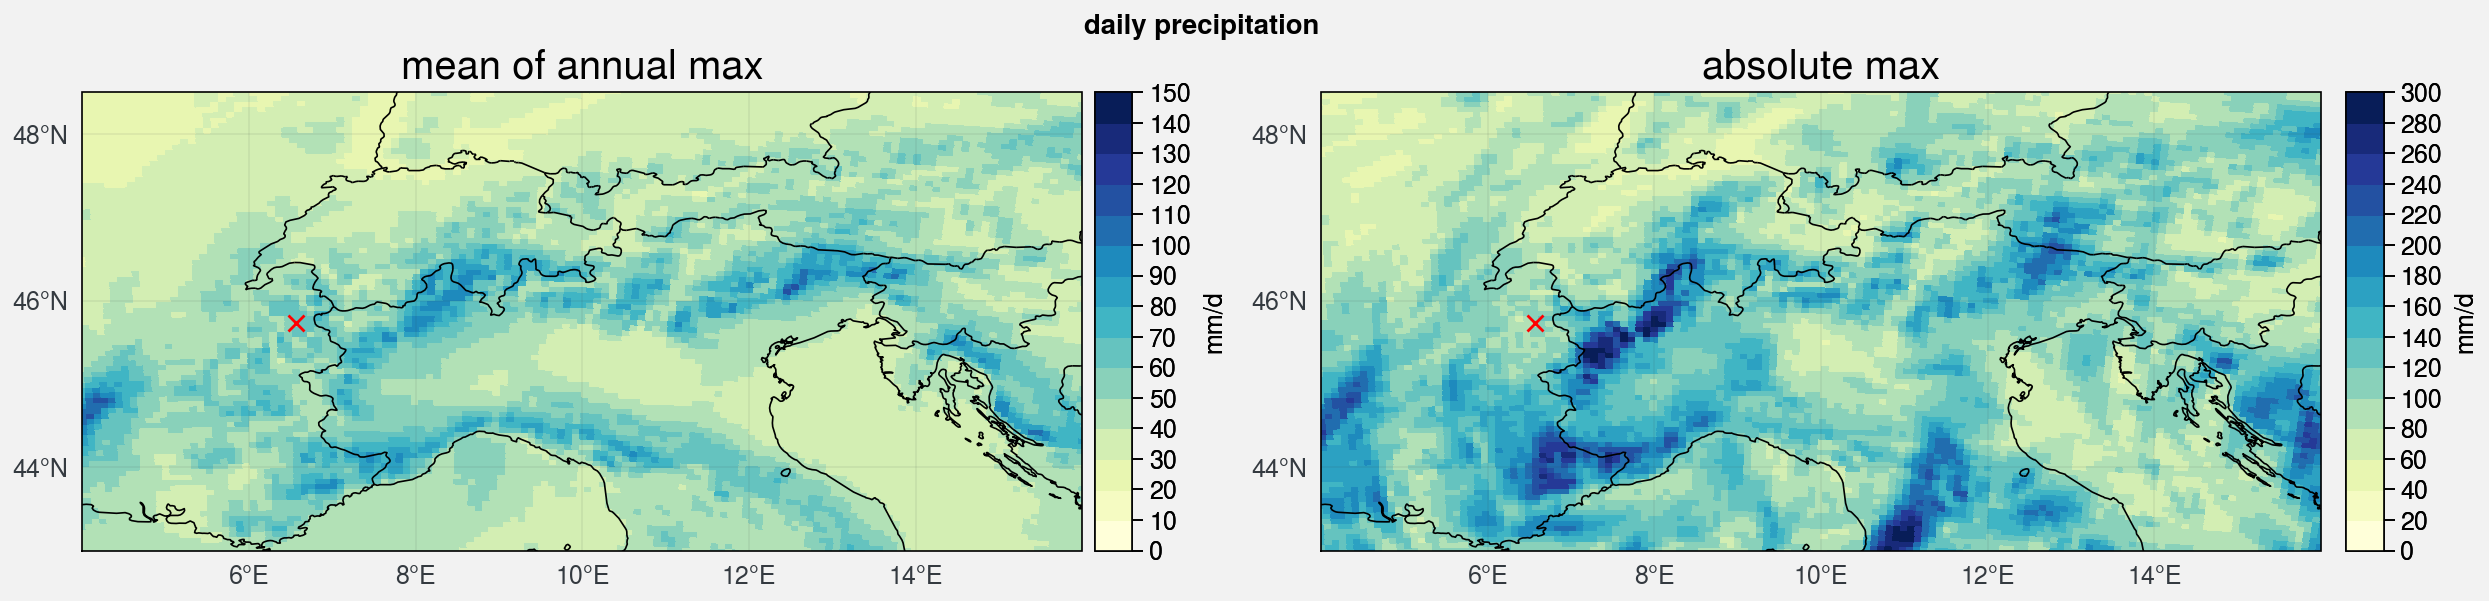

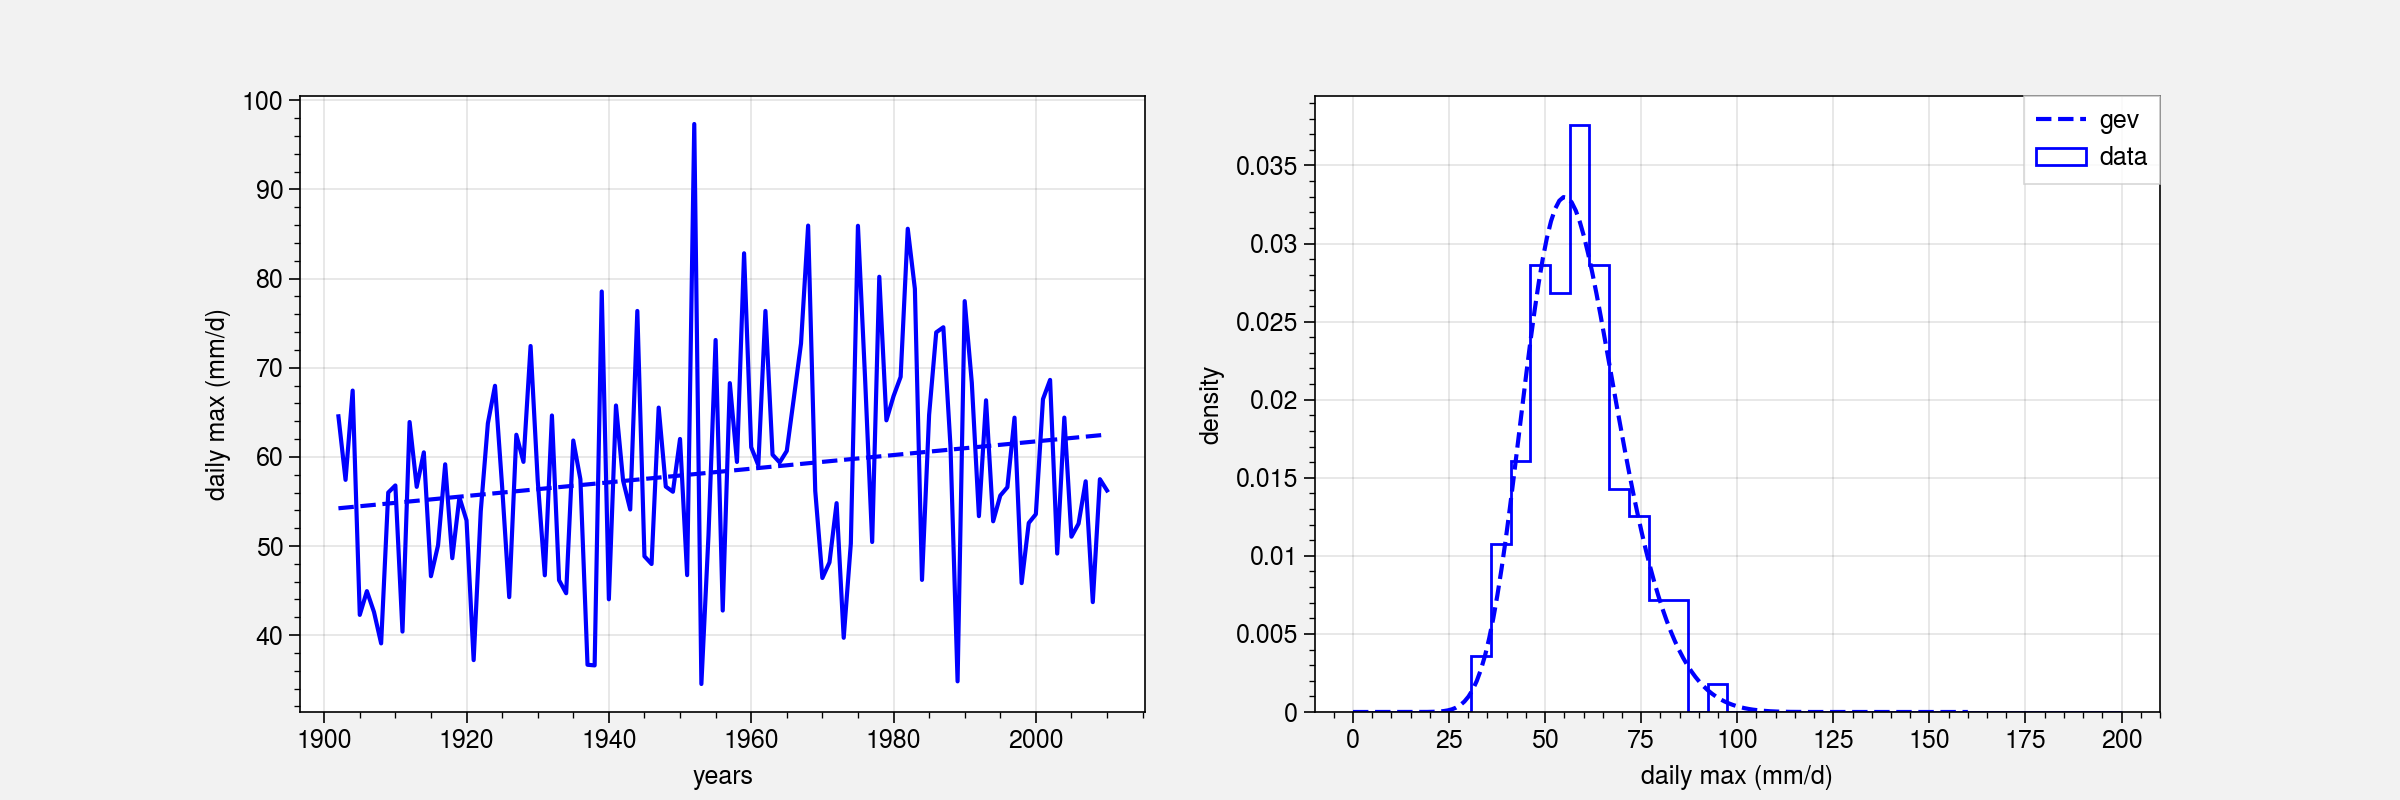

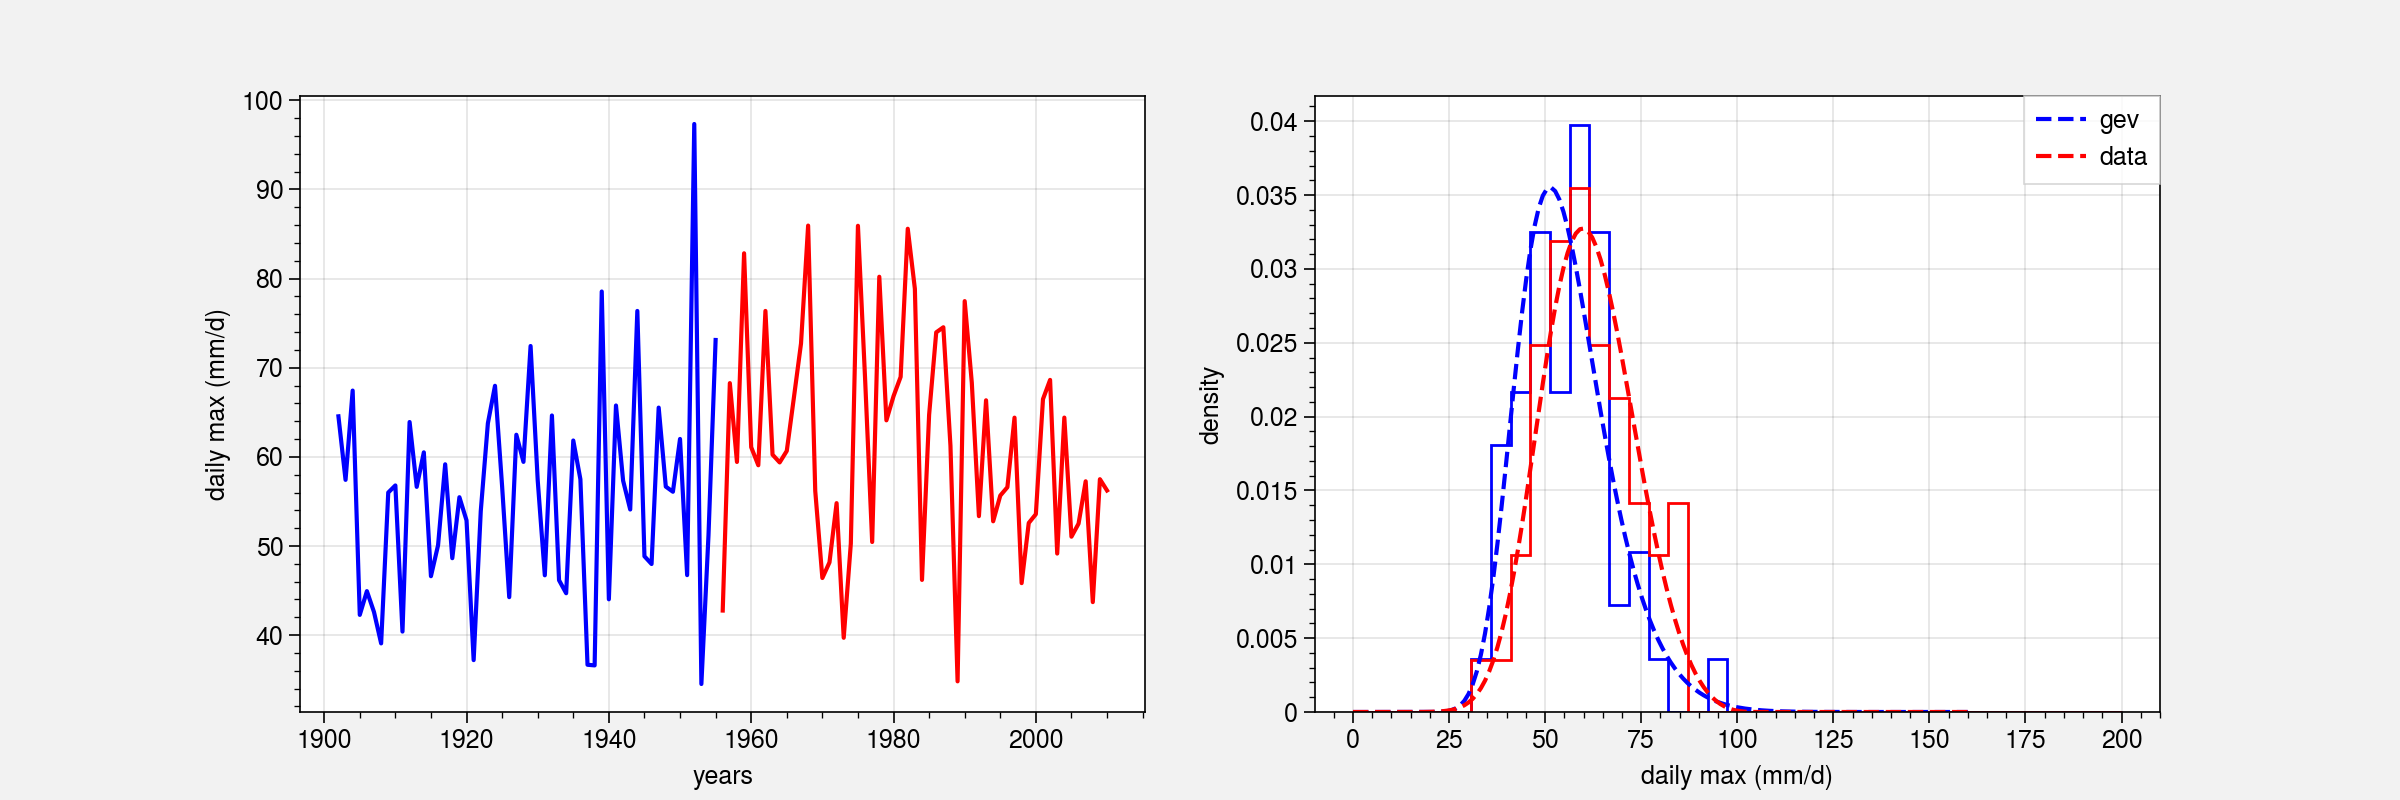

In [28]:
# Levels for the plot
levels=np.linspace(0,150,16)
# Producing the map, excluding the borders of the domain.
f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5,ncols=2)

m0 = ax[0].pcolormesh(ds.LON,ds.LAT,np.mean(les_max_year,axis=0),levels=levels,cmap='YlGnBu')
m1 = ax[1].pcolormesh(ds.LON,ds.LAT,np.max(les_max_year,axis=0),levels=2*levels,cmap='YlGnBu')
ax[0].format(title='mean of annual max',titlesize='20px')
ax[1].format(title='absolute max',titlesize='20px')
f.colorbar(m0, label= 'mm/d',ax=ax[0])
f.colorbar(m1, label= 'mm/d')

ax.format(**normal_format,suptitle="daily precipitation")

i = 62 ; j = 62 # savoie
# i = 52 ; j = 52 # Grenoble
#i = 78 ; j = 63 # lac de garde
ax.plot(ds.LON[j,i], ds.LAT[j,i] ,'xr')

fig,axes = plt.subplots(ncols=2,figsize=(12,4))


first_year = 1902
last_year = 2010
t = np.arange(first_year,last_year+1,1)
maxs = les_max_year[:,j,i]
axes[0].plot(t,maxs,'-b')
m, b = np.polyfit(t,maxs, 1)
x= np.linspace(first_year,last_year,2)
axes[0].plot(x, m*x + b,'--b')
axes[0].set_xlabel('years')
axes[0].set_ylabel('daily max (mm/d)')

axes[1].hist(maxs,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='b')

from scipy.stats import genextreme as gev

shape, loc, scale = gev.fit(maxs)
print(shape, loc, scale)
xx = np.linspace(0,160,150)
yy = gev.pdf(xx, shape, loc, scale)

axes[1].plot(xx, yy, '--b')
axes[1].set_xlabel('daily max (mm/d)')
axes[1].set_ylabel('density')
axes[1].legend(['gev','data'])



fig,axes = plt.subplots(ncols=2,figsize=(12,4))

first_year = 1902
midle_year = 1956
last_year = 2010
t1 = np.arange(first_year,midle_year,1)
t2 = np.arange(midle_year,last_year+1,1)
maxs1 = les_max_year[:len(t1),j,i]
maxs2 = les_max_year[len(t1):,j,i]

axes[0].plot(t1,maxs1,'-b')
axes[0].plot(t2,maxs2,'-r')
# m, b = np.polyfit(t,maxs, 1)
# x= np.linspace(first_year,last_year,2)
# axes[0].plot(x, m*x + b,'--b')
axes[0].set_xlabel('years')
axes[0].set_ylabel('daily max (mm/d)')

axes[1].hist(maxs1,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='b')
axes[1].hist(maxs2,bins=np.linspace(0,200,40),density=True,histtype='step',linewidth=1,color='r')


xx = np.linspace(0,160,150)

shape, loc, scale = gev.fit(maxs1)
print(shape, loc, scale)
yy1 = gev.pdf(xx, shape, loc, scale)

shape, loc, scale = gev.fit(maxs2)
print(shape, loc, scale)
yy2 = gev.pdf(xx, shape, loc, scale)

axes[1].plot(xx, yy1, '--b')
axes[1].plot(xx, yy2, '--r')
axes[1].set_xlabel('daily max (mm/d)')
axes[1].set_ylabel('density')
axes[1].legend(['gev','data'])

In [10]:
# gev_map = np.zeros((3,126,201))
# for i in range(201):
#     print(i,end=' ')
#     for j in range(126):
#         gev_map[:,j,i] =  gev.fit(les_max_year[:,j,i])

0 

/home/philinat/miniconda3/envs/erca/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

In [12]:
# np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/gev_map.npy', gev_map)

In [9]:
gev_map = np.load('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/gev_map.npy')

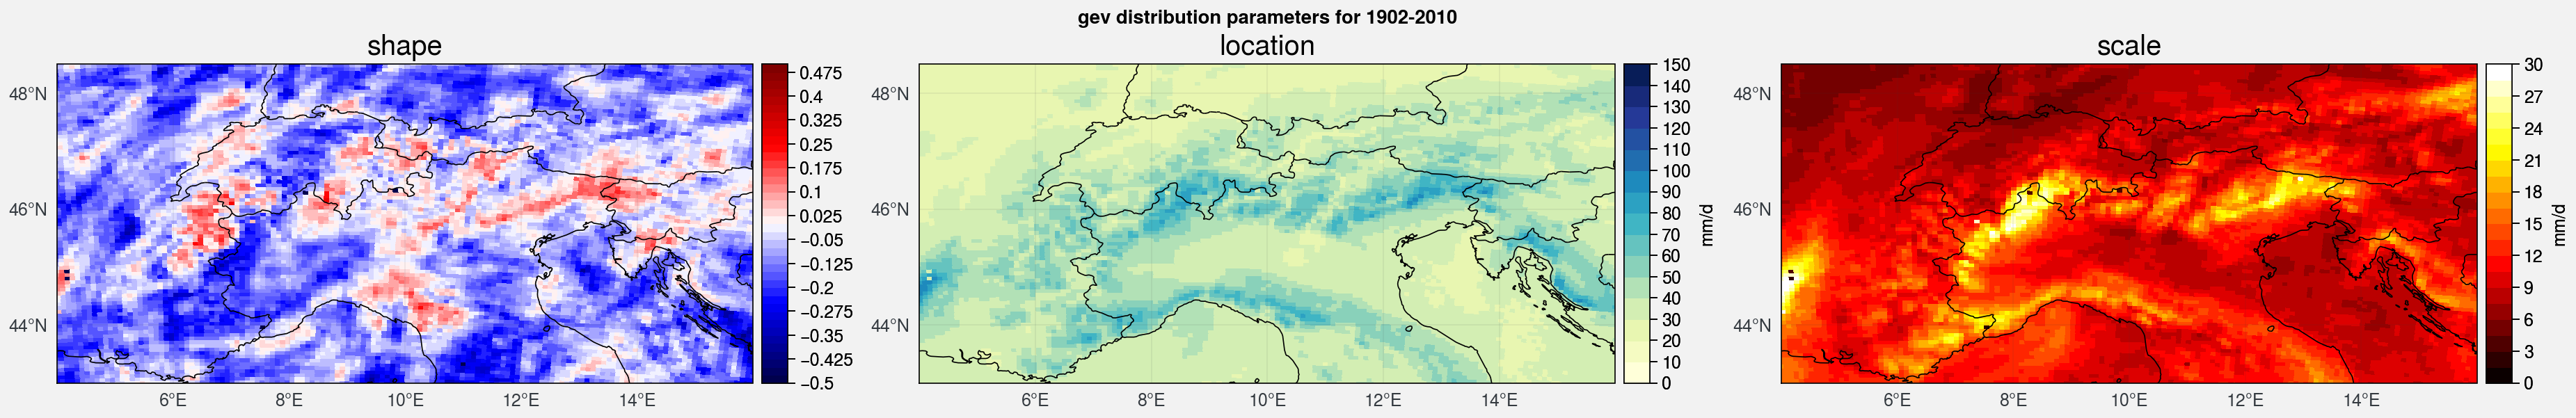

In [40]:
f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5,ncols=3)

for p in range(3):
    m = ax[p].pcolormesh(ds.LON,ds.LAT,gev_map[p,:,:],
            levels=[np.linspace(-0.5,0.5,41),np.linspace(0,150,16),np.linspace(0,30,21)][p],
            cmap=['seismic','YlGnBu','hot'][p]  )
    ax[p].format(title=['shape','location','scale'][p],titlesize='20px')
    f.colorbar(m, label= ['','mm/d','mm/d'][p],ax=ax[p])

ax.format(**normal_format,suptitle="gev distribution parameters for 1902-2010")

In [29]:
gev.ppf(0.5, gev_map[0,j,i], loc=gev_map[1,j,i], scale=gev_map[2,j,i])


57.34665951738165

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.08043519, 3.2415452 , ..., 1.79021192, 1.03575617,
        0.        ],
       [0.        , 3.29345636, 5.74523925, ..., 3.28771115, 1.73621831,
        0.        ],
       ...,
       [0.        , 6.04223403, 5.74522239, ..., 8.91661982, 4.43077816,
        0.        ],
       [0.        , 4.29151694, 4.94132135, ..., 4.18004668, 2.36415188,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

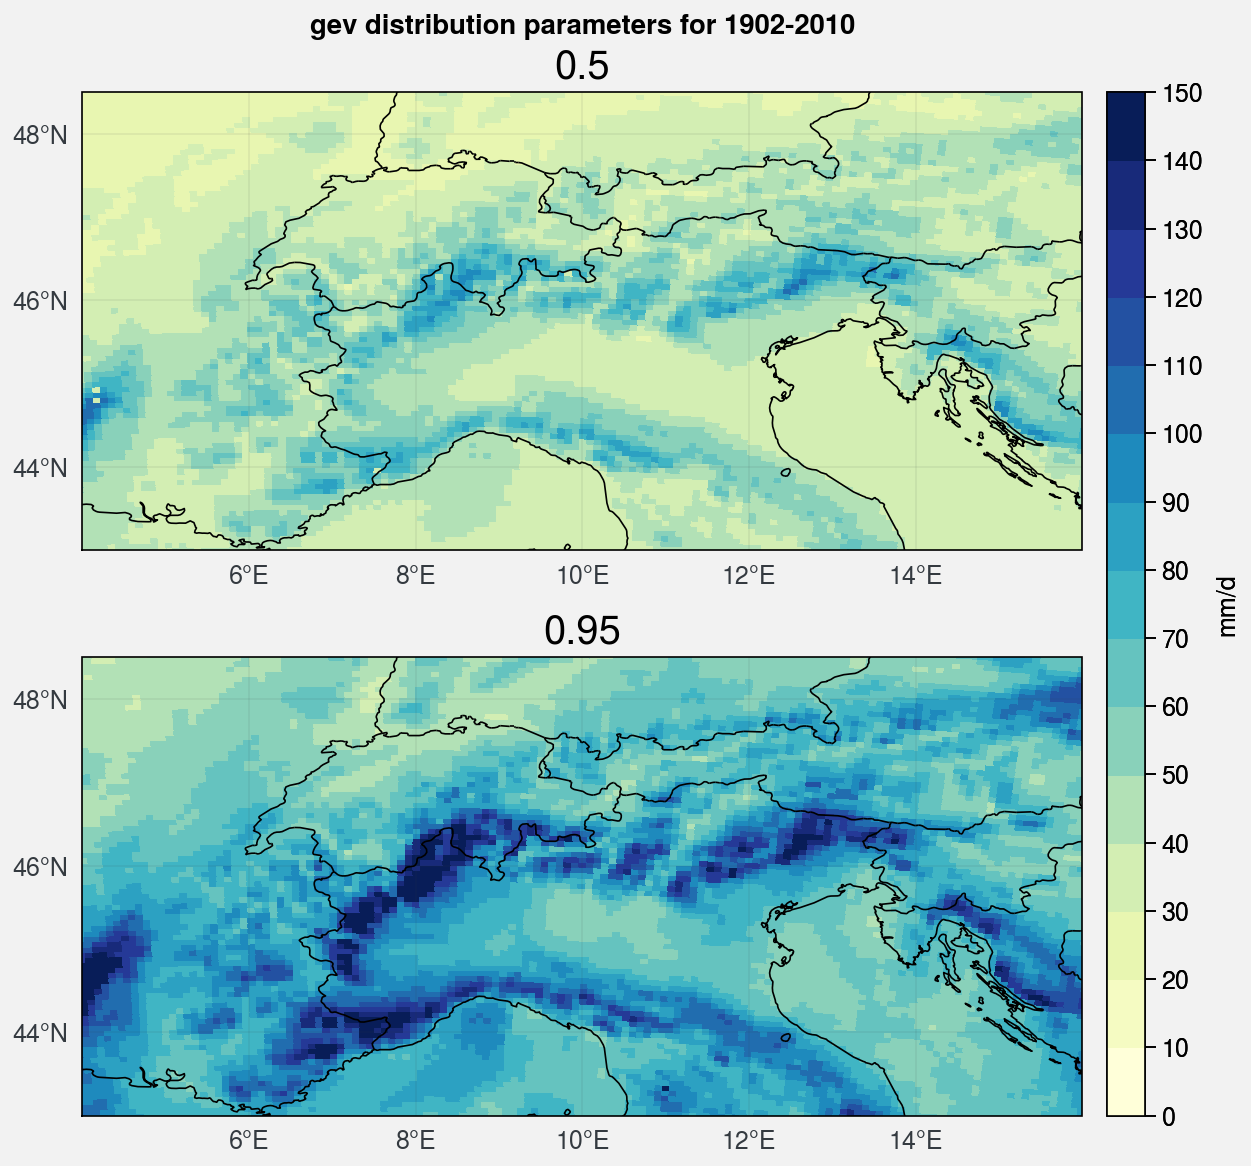

In [62]:
f, ax = pplt.subplots(proj='cyl', share=1, axwidth=5,nrows=2)
percentiles = [0.5,0.95]
for i,perc in enumerate(percentiles):
    data = gev.ppf(perc, gev_map[0,:,:], loc=gev_map[1,:,:], scale=gev_map[2,:,:])
    m = ax[i].pcolormesh(ds.LON,ds.LAT,data,
            levels=np.linspace(0,150,16),
            cmap='YlGnBu'  )
    ax[i].format(title=str(perc),titlesize='20px')
f.colorbar(m, label= 'mm/d')
ax.format(**normal_format,suptitle="gev distribution parameters for 1902-2010")

np.mean(les_max_year,axis=0)


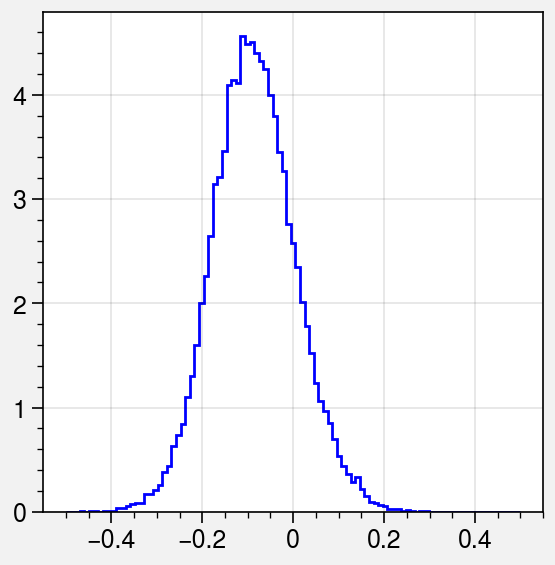

In [63]:
fig,ax=pplt.subplots()
ax.hist(np.ndarray.flatten(gev_map[0,:,:]),bins=np.linspace(-0.5,0.5,100),density=True,histtype='step',linewidth=1,color='b')
plt.show()

In [64]:
# function for seasonal mean
def season_max(ds):
    return ds.groupby("time.season").max(dim="time")

In [4]:
first_year = 1902
last_year = 2010
les_season_max = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBrr.'+str(year)+'.nc')
    ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/daily/ICE.ERA-20C_v1.EUf.MBsf.'+str(year)+'.nc')
    season_max_year=(ds_rr.MBrr+ds_sf.MBsf).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_max[year-first_year] = season_max_year
    
np.save('/home/philinat/Stage-M2/saved_data_MAR_ERA20C_daily_mean_max/les_season_max.npy', les_season_max)

1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 

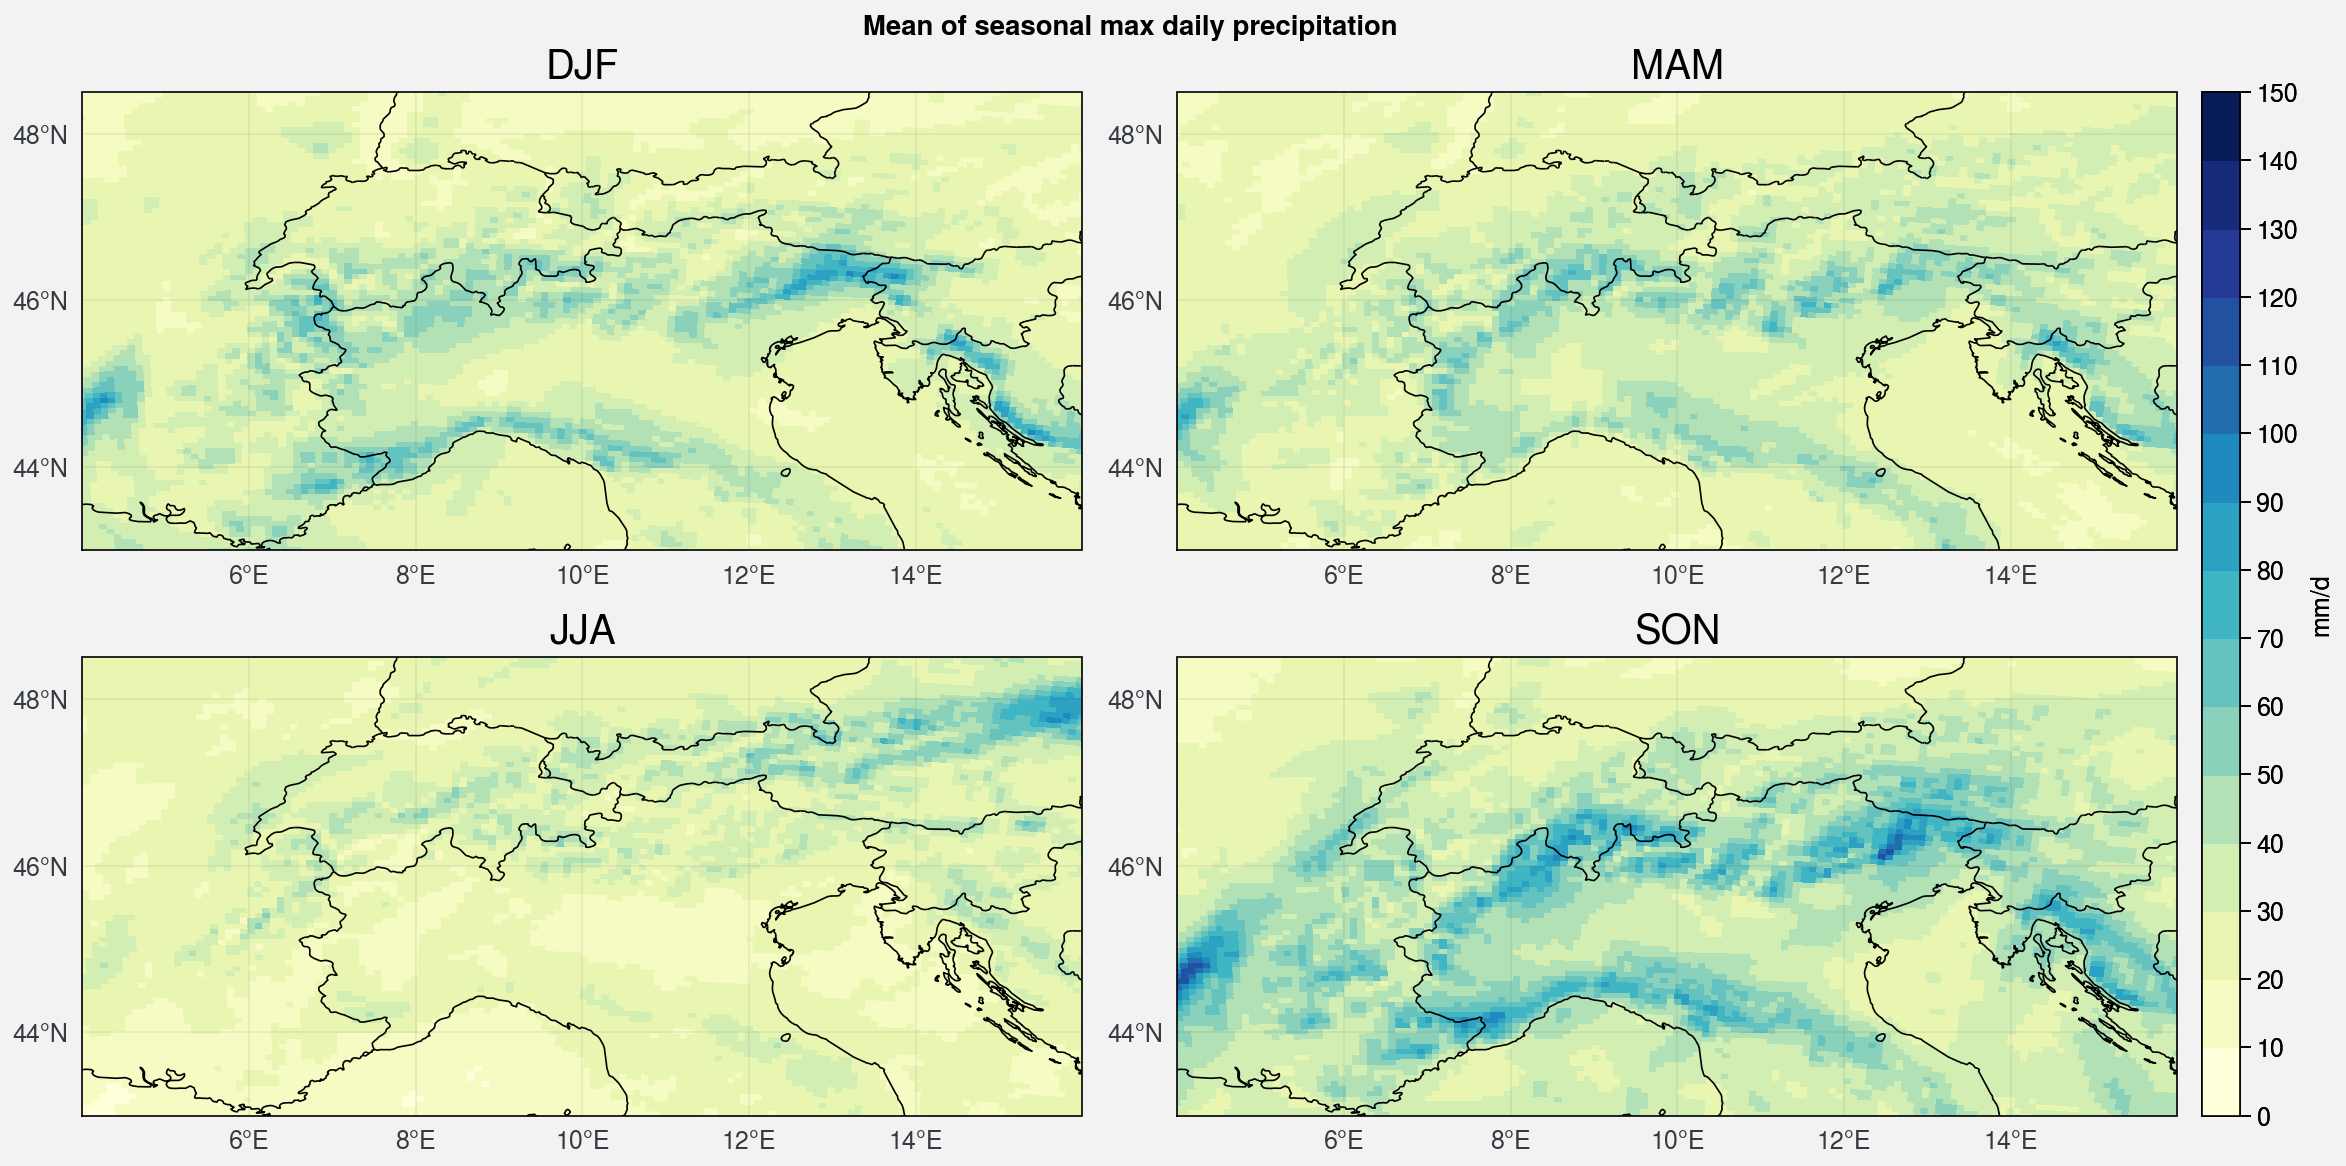

In [77]:
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.mean(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,150,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")


In [72]:
season_max_year.season.data

array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)